In [2]:
import pandas as pd

with open('data/divemt/data/processed/merged/full_main.tsv', 'r') as in_file:
    df_stats = pd.read_csv(in_file, delimiter='\t')
    i = 0

In [3]:
import pandas as pd

with open('data/divemt/data/processed/merged/full_main_texts.tsv', 'r') as in_file:
    df_texts = pd.read_csv(in_file, delimiter='\t')

In [4]:
df_stats_and_texts = pd.concat((df_stats, df_texts['mt_text'], df_texts['tgt_text']), axis=1).dropna()

In [5]:
import rsatoolbox

import numpy as np
from transformers import AutoTokenizer, AutoModel

import matplotlib.pyplot as plt

from torch import eye, matmul, Tensor
from torch.nn.functional import pad

from rsatoolbox.vis.rdm_plot import show_rdm
from rsatoolbox.rdm.rdms import RDMs

from rsatoolbox.rdm import compare

from scipy.stats import kendalltau

def project_embedding(embeddings: Tensor, dim : int =2, start=0):
    projectionMatrix = pad(eye(dim), (0, embeddings.shape[0], start, (embeddings.shape[1] - start) - dim), value=0)

    result = matmul(embeddings, projectionMatrix)[:, :dim]

    return result.numpy(force=True)

def calc_score(tokenizer, model, input):
    la_example_out = tokenizer(df_stats_and_texts['mt_text'][input], return_tensors='pt', padding='max_length', truncation=True, max_length=50)
    la_example_ref = tokenizer(df_stats_and_texts['tgt_text'][input], return_tensors='pt', padding='max_length', truncation=True, max_length=50)

    tokens_out = [tokenizer.decode(i.item()) for i in la_example_out['input_ids'][0]]
    tokens_ref = [tokenizer.decode(i.item()) for i in la_example_ref['input_ids'][0]]

    max_len = max(len([i for i in tokens_out if i != "[PAD]"]), len([i for i in tokens_ref if i != "[PAD]"]))

    tokens_out = tokens_out[:max_len]
    tokens_ref = tokens_ref[:max_len]

    mdl_out = model(**la_example_out, output_hidden_states=True, output_attentions=True)
    mdl_ref = model(**la_example_ref, output_hidden_states=True, output_attentions=True)

    embeddings_out = mdl_out['hidden_states'][0][0][:max_len]
    embeddings_ref = mdl_ref['hidden_states'][0][0][:max_len]

    attn_out = mdl_out['attentions'][0][0][:max_len]
    attn_ref = mdl_ref['attentions'][0][0][:max_len]

    rand_dim = np.random.randint(low=0, high=embeddings_out.shape[1] - 2)

    projection_out = project_embedding(embeddings_out, start=rand_dim)
    projection_ref = project_embedding(embeddings_ref, start=rand_dim)

    rdm_out = rsatoolbox.rdm.calc_rdm(rsatoolbox.data.Dataset(embeddings_out.detach().numpy()))
    rdm_ref = rsatoolbox.rdm.calc_rdm(rsatoolbox.data.Dataset(embeddings_ref.detach().numpy()))

    rdm_out.pattern_descriptors = {'index': tokens_out}
    rdm_ref.pattern_descriptors = {'index': tokens_ref}

    # rdm_out.append(rdm_ref)

    rsa_kendall = kendalltau(rdm_out.dissimilarities, rdm_ref.dissimilarities, variant='c')
    rsa_pearson = compare(rdm_out, rdm_ref, method='corr')
    rsa_spearman = compare(rdm_out, rdm_ref, method='rho-a')

    return rsa_kendall, rsa_pearson, rsa_spearman, rdm_out, rdm_ref, projection_out, projection_ref, tokens_out, tokens_ref

/home/alexis/Alexis (WSL)/env/school/CompLexSem/group-project/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import random as rd
from tqdm import tqdm
from enum import Enum

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base")
model = AutoModel.from_pretrained("FacebookAI/xlm-roberta-base")

similarities = []
scores = []

df_stats_and_texts['edits_per_word'] = df_stats_and_texts['tot_edits'] / df_stats_and_texts['mt_len_wrd']
df_stats_and_texts['edits_per_chr'] = df_stats_and_texts['tot_edits'] / df_stats_and_texts['mt_len_chr']

df_stats_and_texts['rsa_kendall'] = np.nan
df_stats_and_texts['rsa_pearson'] = np.nan
df_stats_and_texts['rsa_spearman'] = np.nan

df_stats_and_texts['subject_id'] = df_stats_and_texts['subject_id'].map(lambda x: x[:3])

colors = {
    'ita': 'red',
    'ara': 'black',
    'nld': 'orange',
    'tur': 'turquoise',
    'ukr': 'yellow',
    'vie': 'green'
}

df_stats_and_texts['color'] = df_stats_and_texts['subject_id'].map(colors)


for m in tqdm(df_stats_and_texts.index.values):
    # rand_i = rd.choice(df_stats_and_texts.index)

    kendall, pearson, spearman, rdm_out, rdm_ref, projection_out, projection_ref, tokens_out, tokens_ref = calc_score(tokenizer, model, m)

    # out_x = projection_out[:, 0]
    # out_y = projection_out[:, 1]

    # ref_x = projection_ref[:, 0]
    # ref_y = projection_ref[:, 1]

    # ax.scatter(out_x, out_y, c='orange')
    # ax.scatter(ref_x, ref_y, c='purple')

    # for i, txt in enumerate(tokens_out):
    #     ax.annotate(txt, (out_x[i], out_y[i]))

    # for i, txt in enumerate(tokens_ref):
    #     ax.annotate(txt, (ref_x[i], ref_y[i]))

    # print(f"similarity:\t\t{result.statistic}")
    # print(f"actual score:\t\t{df_stats_and_texts['words_per_minute'][rand_i]}")
    # print()

    # if result.statistic != 1 and df_stats_and_texts['time_per_word'][rand_i] <= 100 and "ht" not in df_stats_and_texts["unit_id"][rand_i]:
    df_stats_and_texts.loc[m, 'rsa_kendall'] = kendall.statistic
    df_stats_and_texts.loc[m, 'rsa_pearson'] = pearson
    df_stats_and_texts.loc[m, 'rsa_spearman'] = spearman


100%|██████████| 5160/5160 [13:53<00:00,  6.19it/s]


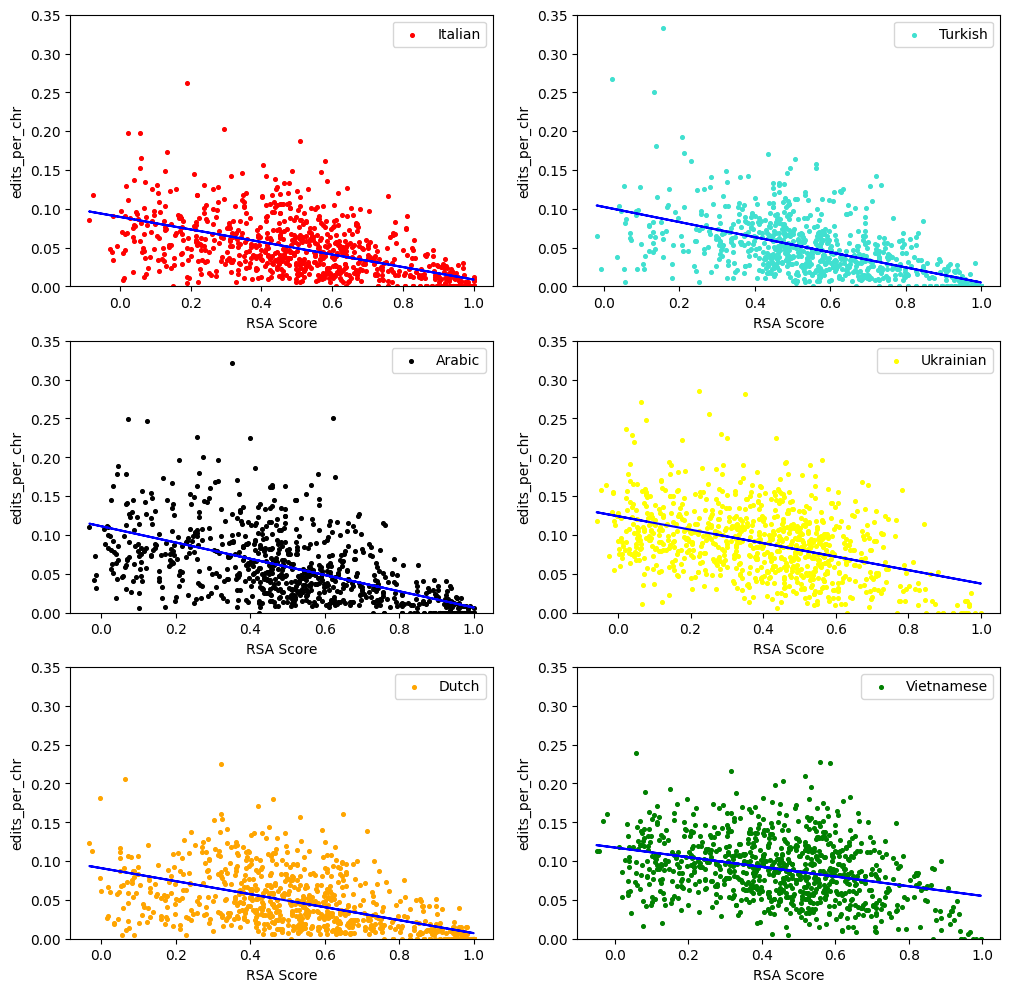

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(12,12))

y_axis = 'edits_per_chr'
langs = list(colors.keys())

languages = {
    'ita': 'Italian',
    'ara': 'Arabic',
    'nld': 'Dutch',
    'tur': 'Turkish',
    'ukr': 'Ukrainian',
    'vie': 'Vietnamese'
}

for ax_x in range(len(axes)):
    for ax_y in range(len(axes[ax_x])):
        ax = axes[ax_x][ax_y]
        ax.set_xlabel("RSA Score")
        ax.set_ylabel(y_axis)

        lang = langs[ax_x + 3 * ax_y]
        df_lang = df_stats_and_texts.loc[df_stats_and_texts['subject_id'] == lang]
        similarities = df_lang['rsa_kendall']
        scores = df_lang[y_axis]

        ax.set_ylim(0, 0.35)
        ax.set_xlim(0, 1)

        A = np.vstack([similarities, np.ones(similarities.shape[0])]).T
        m, c = np.linalg.lstsq(A, scores)[0]

        _ = ax.plot(similarities, m*similarities + c, 'blue')

        ax.scatter(similarities, scores, c=colors[lang], s=7, label=languages[lang])
        ax.legend()

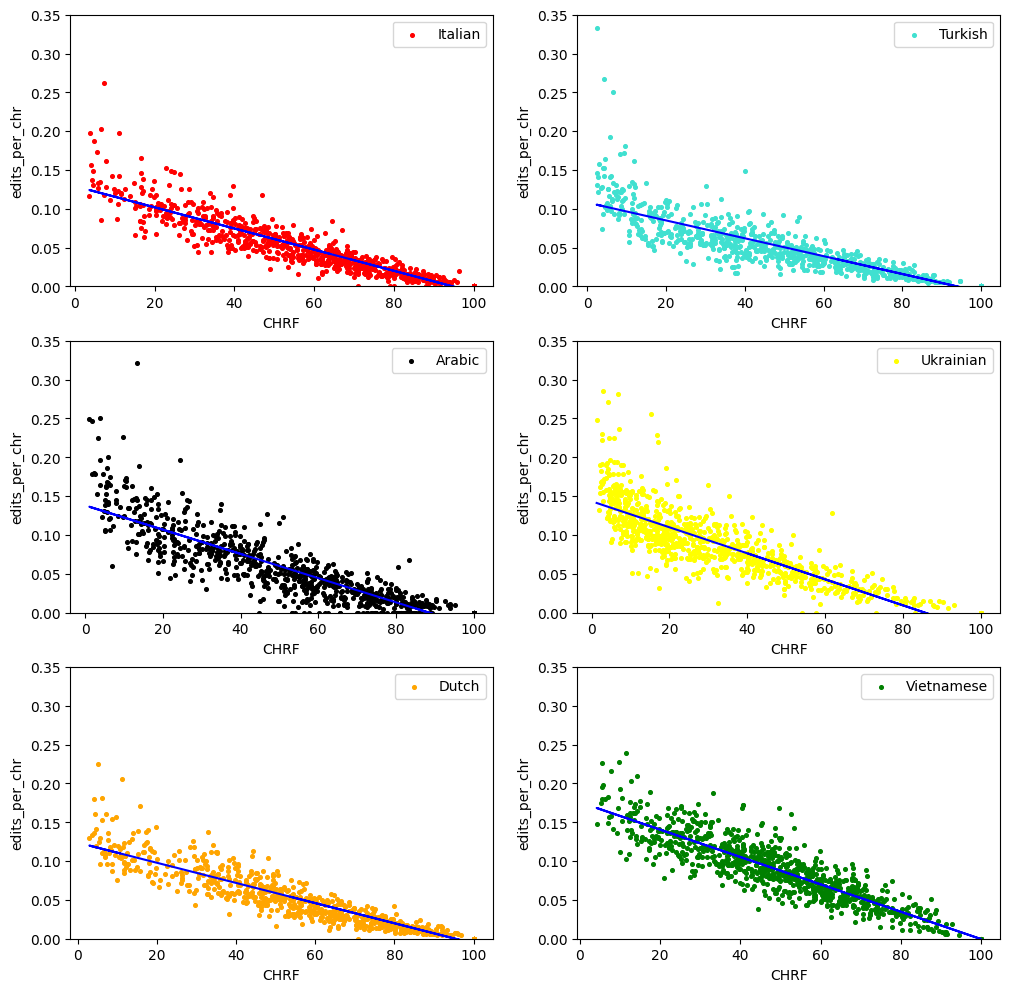

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(12,12))

y_axis = 'edits_per_chr'
langs = list(colors.keys())

for ax_x in range(len(axes)):
    for ax_y in range(len(axes[ax_x])):
        ax = axes[ax_x][ax_y]
        ax.set_xlabel("CHRF")
        ax.set_ylabel(y_axis)

        lang = langs[ax_x + 3 * ax_y]
        df_lang = df_stats_and_texts.loc[df_stats_and_texts['subject_id'] == lang]
        similarities = df_lang['bleu']
        scores = df_lang[y_axis]

        ax.set_ylim(0, 0.35)
        ax.set_xlim(0, 100)

        A = np.vstack([similarities, np.ones(similarities.shape[0])]).T
        m, c = np.linalg.lstsq(A, scores)[0]

        _ = ax.plot(similarities, m*similarities + c, 'blue')

        ax.scatter(similarities, scores, c=colors[lang], s=7, label=languages[lang])
        ax.legend()

/tmp/ipykernel_1444/1165091068.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lang['bertscore'] = bertscore.compute(


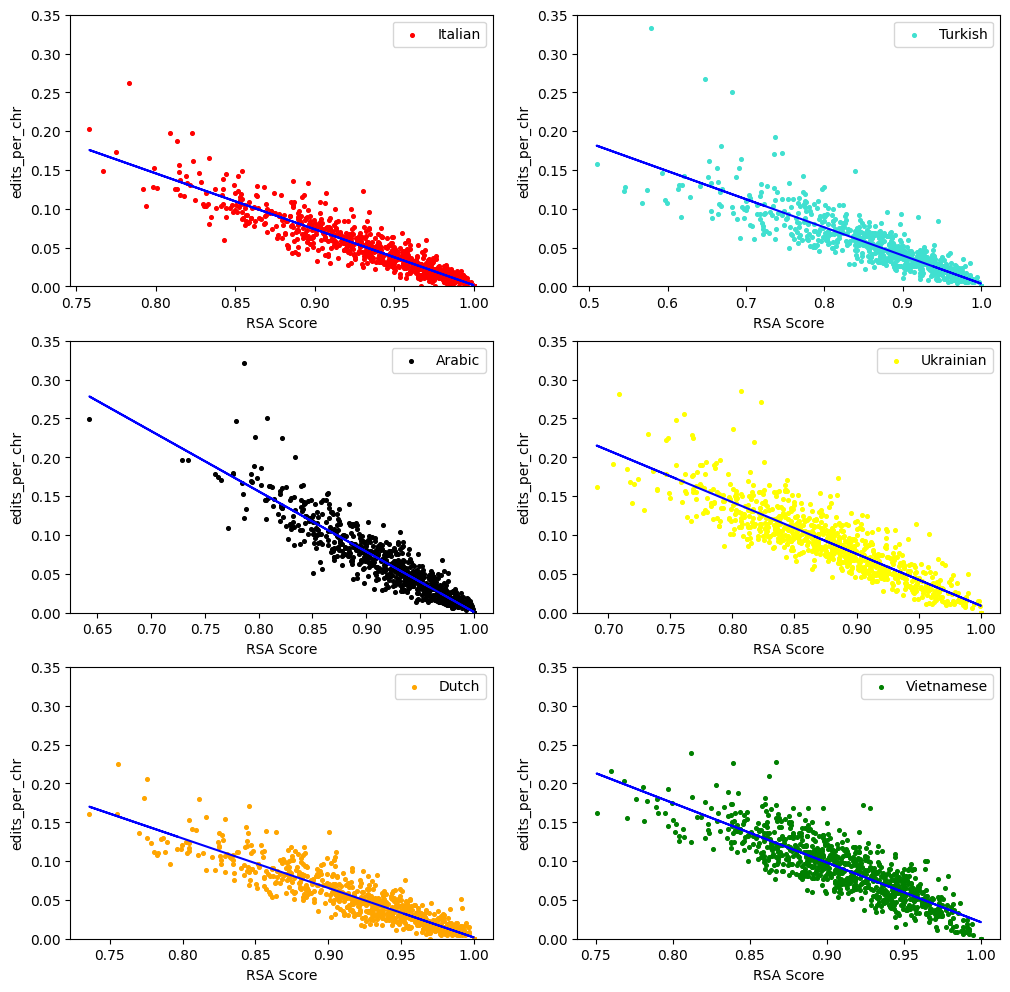

In [ ]:
from evaluate import load

fig, axes = plt.subplots(3, 2, figsize=(12,12))

results = []

df_stats_and_texts['bertscore'] = np.nan

bertscore = load("bertscore")
# for b in tqdm(df_stats_and_texts.index.values):
#     results.append(
#         bertscore.compute(
#             predictions=[df_stats_and_texts['mt_text'][b]], 
#             references=[df_stats_and_texts['tgt_text'][b]], 
#             lang=df_stats_and_texts['subject_id'][b][:2] if not df_stats_and_texts['subject_id'][b] == 'tur' else 'tr')['f1']
#     )

for ax_x in range(len(axes)):
    for ax_y in range(len(axes[ax_x])):
        ax = axes[ax_x][ax_y]
        ax.set_xlabel("BERTscore")
        ax.set_ylabel(y_axis)

        lang = langs[ax_x + 3 * ax_y]
        df_lang = df_stats_and_texts.loc[df_stats_and_texts['subject_id'] == lang]

        df_lang['bertscore'] = bertscore.compute(
            predictions=df_lang['mt_text'].values, 
            references=df_lang['tgt_text'].values, 
            lang=lang[:2] if not lang == 'tur' else 'tr')['f1']
        

        similarities = df_lang['bertscore']
        scores = df_lang[y_axis]

        ax.set_ylim(0, 0.35)
        ax.set_xlim(0, 100)

        A = np.vstack([similarities, np.ones(len(similarities))]).T
        m, c = np.linalg.lstsq(A, scores)[0]

        _ = ax.plot(similarities, m*similarities + c, 'blue')

        ax.scatter(similarities, scores, c=colors[lang], s=7, label=languages[lang])
        ax.legend()

        results.append(similarities)

plt.show()


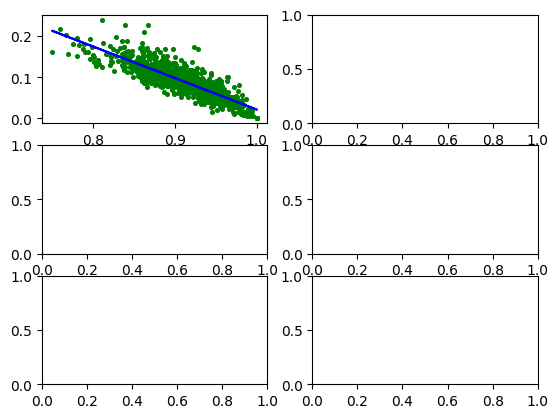

In [ ]:
fig, ax = plt.subplots(3, 2)
ax[0][0].scatter(similarities, scores, c=colors[lang], s=7, label=languages[lang])

A = np.vstack([similarities, np.ones(len(similarities))]).T
m, c = np.linalg.lstsq(A, scores)[0]

_ = ax[0][0].plot(similarities, m*similarities + c, 'blue')

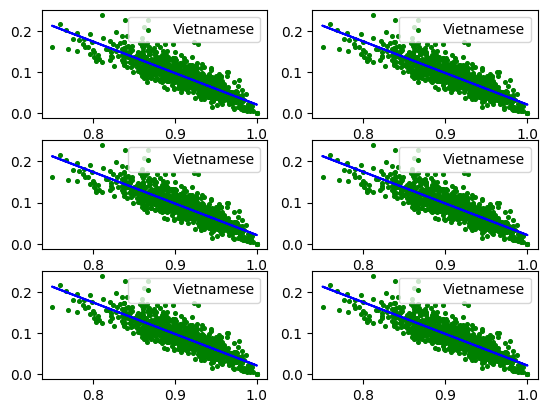

In [ ]:
        
fig, ax = plt.subplots(3, 2)

for ax_x in range(len(axes)):
    for ax_y in range(len(axes[ax_x])):
        ax = axes[ax_x][ax_y]
        similarities = df_lang['bertscore']
        scores = df_lang[y_axis]

        # y.set_ylim(0, 15)

        A = np.vstack([similarities, np.ones(len(similarities))]).T
        m, c = np.linalg.lstsq(A, scores)[0]

        _ = ax.plot(similarities, m*similarities + c, 'blue')

        ax.scatter(similarities, scores, c=colors[lang], s=7, label=languages[lang])
        ax.legend()

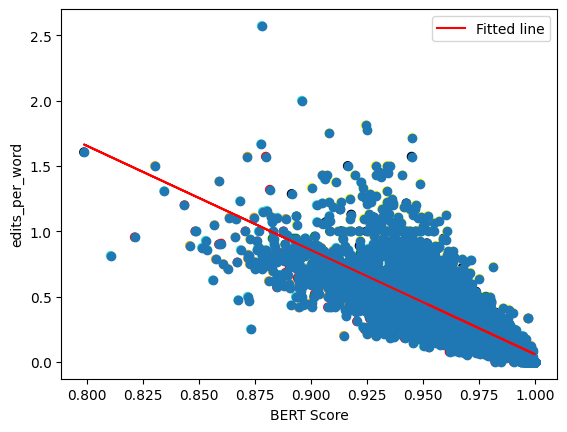

In [ ]:
fig, ax = plt.subplots()

ax.set_ylabel(y_axis)
# ax.set_ylim(0, 100)

ax.set_xlabel("BERT Score")
# ax.set_xlim(0, 99)

x = results
y = df_stats_and_texts[y_axis]

A = np.vstack([x, np.ones(x.shape[0])]).T
m, c = np.linalg.lstsq(A, y)[0]

ax.scatter(x, y, color=df_stats_and_texts['color'])

_ = plt.plot(x, y, 'o')
_ = plt.plot(x, m*x + c, 'r', label='Fitted line')
_ = plt.legend()